In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import json
import pandas as pd
import sklearn
from tqdm import tqdm
import glob
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [19]:
# obtained from first month feature file
feature_columns = ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time (LST)', 'Year', 'Month', 'Day', 'Time (LST)', 'Temp (°C)',
       'Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag',
       'Rel Hum (%)', 'Rel Hum Flag', 'Precip. Amount (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather']

# Feature File Preparation

In [20]:
monthly_data_files = glob.glob("Data/2023-Ottawa-Weather/*.csv")

all_feature_dfs = []
for file in monthly_data_files:
    df = pd.read_csv(file)
    all_feature_dfs.append(df[feature_columns])

all_features = pd.concat(all_feature_dfs, axis=0, ignore_index = True)

In [21]:
# do some innitial pre-processing for performing the join
all_features['Date/Time (LST)'] = pd.to_datetime(all_features['Date/Time (LST)'])
all_features = all_features.rename(columns={'Date/Time (LST)':'DateTime'})

# Target File Preparation

In [22]:
target_df = pd.read_csv("Data/FSS Main 2023.csv")
target_df['DateTime'] = pd.to_datetime(target_df['DateTime'])

In [23]:
# drop duplicates
target_df_duplicated = target_df[target_df.duplicated(subset=['DateTime'], keep=False)]
target_df_nodup = target_df.drop_duplicates(subset=['DateTime'], keep='first')

In [24]:
# slide the datetime of meter reading to 1 hr before the recorded time to align with the datetime column of features
target_df_nodup.loc[:, 'DateTime'] = target_df_nodup['DateTime'] - timedelta(hours=1)
# rename FSS Main to Meter Reading (KWHr)
target_df_nodup = target_df_nodup.rename(columns = {'FSS Main':'Meter Reading (KWHr)'})

# Merge Dataframes based on Datetime

In [25]:
merged_df = pd.merge(target_df_nodup, all_features, on='DateTime', how='left')
merged_columns = " ; ".join(feature_columns).replace("Date/Time (LST)","DateTime").split(" ; ") + ["Meter Reading (KWHr)"]
# rearrange columns
merged_df = merged_df[merged_columns]

In [26]:
# write the merged raw data
merged_df.to_csv('Data/merged_data_newData.csv', index=False)

# Perform Feature Pre-Processing

In [27]:
data_df = pd.read_csv("Data/merged_data_newData.csv")

In [28]:
# find number of missing values per column
missing_stats = data_df.isnull().sum()
missing_stats

Longitude (x)              0
Latitude (y)               0
Station Name               0
Climate ID                 0
DateTime                   0
Year                       0
Month                      0
Day                        0
Time (LST)                 0
Temp (°C)                  2
Temp Flag               8756
Dew Point Temp (°C)        2
Dew Point Temp Flag     8756
Rel Hum (%)                2
Rel Hum Flag            8756
Precip. Amount (mm)     8756
Precip. Amount Flag     8756
Wind Dir (10s deg)         6
Wind Dir Flag           8756
Wind Spd (km/h)            2
Wind Spd Flag           8756
Visibility (km)            2
Visibility Flag         8756
Stn Press (kPa)            2
Stn Press Flag          8756
Hmdx                    7600
Hmdx Flag               8756
Wind Chill              6236
Wind Chill Flag         8756
Weather                 4657
Meter Reading (KWHr)       0
dtype: int64

## Innitial pre-processing steps to drop columns based on the following criteria:
1. Columns which are completely empty and therefore cannot be filled.
2. Columns such as DateTime are redundant, as "Month", "Day" and "Time" are seperate columns that store the same information.
3. Columns that are filled but are only filled with the same value (won't have any correlation with target and can be dropped).

In [29]:
# drop columns which are completely empty
drop_cols = missing_stats[(missing_stats==len(data_df))].index.to_list()

# additional drop columns with same value for all the rows
add_drop = [col for col in data_df.columns if data_df[col].nunique()==1]
drop_cols += add_drop

# drop other columns based on domain knowledge (non useful details)
domain_drop = ['DateTime']
drop_cols += domain_drop

print("Columns to drop: ", drop_cols)

Columns to drop:  ['Temp Flag', 'Dew Point Temp Flag', 'Rel Hum Flag', 'Precip. Amount (mm)', 'Precip. Amount Flag', 'Wind Dir Flag', 'Wind Spd Flag', 'Visibility Flag', 'Stn Press Flag', 'Hmdx Flag', 'Wind Chill Flag', 'Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year', 'DateTime']


In [30]:
data_df.drop(columns=drop_cols, inplace = True)

In [31]:
# now replace time value to categorical values for post 1-hot encoding
# Convert Time or hour of the day to categorical columns
data_df['Time (LST)'] = pd.to_datetime(data_df['Time (LST)'])
# create labels for hours
labels_hrs = [f'hour_{i}' for i in range(0,24)]
data_df['Time (LST)'] = pd.cut(data_df['Time (LST)'].dt.hour, bins=range(0,25), right=False, labels=labels_hrs)

## Plot some columns with missing values (To determine which mode of central tendancy to use for filling missing values)

Mean Value:  29.60553633217993 Median Value:  29.0 Mode Value:  0    28.0
dtype: float64


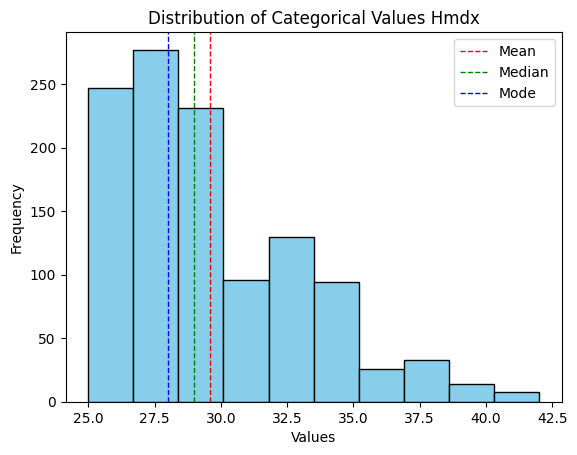

Mean Value:  -10.91904761904762 Median Value:  -9.0 Mode Value:  0   -6.0
dtype: float64


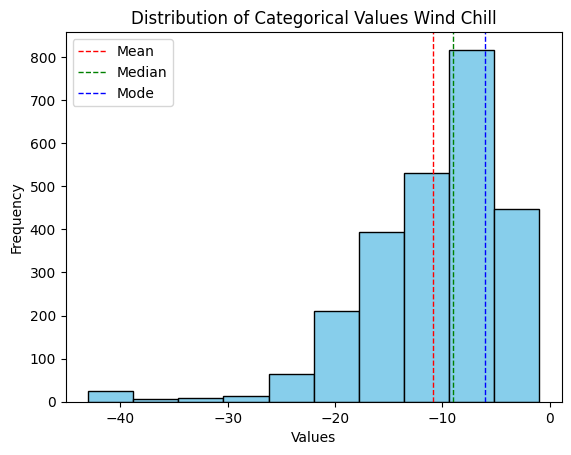

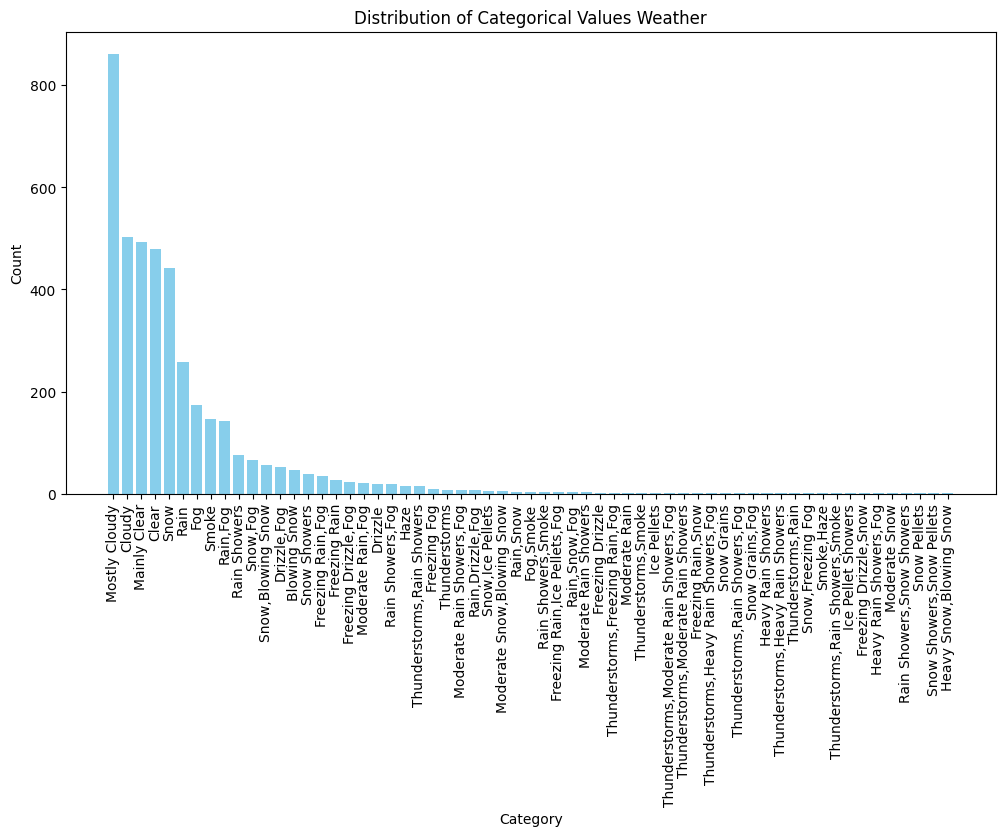

In [32]:
def plot_feature_distribution(data_df, column):
    # we observe that Hmdx, Wind Chill and Weather have the most number of missing values
    chop = data_df[column].dropna()
    
    if data_df[column].dtype in ["category","object"]:
        # for categorical columns
        category_counts = chop.value_counts()
        # print(category_counts.index.tolist())
        plt.figure(figsize=(12, 6))
        plt.bar(category_counts.index, category_counts.values, color='skyblue', width = 0.8)
        plt.xticks(rotation=90)
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.title(f'Distribution of Categorical Values {column}')
        
    elif data_df[column].dtype in ["float64","int64"]:
        # for other continous variable columns
        plt.hist(chop, bins=10, color='skyblue', edgecolor='black')
        # Calculate mean value
        print("Mean Value: ", chop.mean(), "Median Value: ", chop.median(), "Mode Value: ", chop.mode())
        # Add a vertical line at the mean value
        plt.axvline(chop.mean(), color='red', linestyle='dashed', linewidth=1)
        plt.axvline(chop.median(), color='green', linestyle='dashed', linewidth=1)
        plt.axvline(chop.mode()[0], color='blue', linestyle='dashed', linewidth=1)

        plt.legend(['Mean', 'Median', 'Mode'])

        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Categorical Values {column}')
        
    plt.show()
    
# plot distribbutions and measure of central tendencies
plot_feature_distribution(data_df, "Hmdx")
plot_feature_distribution(data_df, "Wind Chill")
plot_feature_distribution(data_df, "Weather")

## Fill missing values based on most frequent occurrence (mode as a measure of central tendancy)

In [33]:
# fill the missing values
data_df = data_df.fillna(data_df.mode().iloc[0])

## Pre-process the Weather column
The weather column has values which are concatenation of weather conditions. eg: "Rain,haze". We can split these columns into separate categorical variables for "Rain" and "Haze". 

In [34]:
# split the Weather column (as its based on concatenation of multiple weather attributes)
weather_values = set(data_df['Weather'].tolist())

weather_values = [x.split(",") for x in weather_values]
weather_values_mod = []
for weath_sub in weather_values:
    weather_values_mod.extend(weath_sub)
weather_values = set(weather_values_mod)
print("Unique weather categories: ", weather_values)
print("Num unique categories: ", len(weather_values))

Unique weather categories:  {'Rain', 'Cloudy', 'Fog', 'Drizzle', 'Clear', 'Freezing Drizzle', 'Ice Pellet Showers', 'Haze', 'Snow Pellets', 'Moderate Rain', 'Moderate Snow', 'Heavy Rain Showers', 'Snow Showers', 'Mainly Clear', 'Freezing Fog', 'Freezing Rain', 'Heavy Snow', 'Rain Showers', 'Mostly Cloudy', 'Blowing Snow', 'Ice Pellets', 'Snow', 'Thunderstorms', 'Snow Grains', 'Smoke', 'Moderate Rain Showers'}
Num unique categories:  26


In [35]:
for un_weath_category in weather_values:
    # create a category name same as the unique category
    data_df[un_weath_category]=data_df['Weather'].apply(lambda col_val: int(un_weath_category in col_val.split(",")))

In [36]:
pd.set_option('display.max_columns', None)
data_df.head(5)

,Month,Day,Time (LST),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Meter Reading (KWHr),Rain,Cloudy,Fog,Drizzle,Clear,Freezing Drizzle,Ice Pellet Showers,Haze,Snow Pellets,Moderate Rain,Moderate Snow,Heavy Rain Showers,Snow Showers,Mainly Clear,Freezing Fog,Freezing Rain,Heavy Snow,Rain Showers,Mostly Cloudy,Blowing Snow,Ice Pellets,Snow,Thunderstorms,Snow Grains,Smoke,Moderate Rain Showers
0,1,1,hour_0,3.0,3.0,100.0,28.0,11.0,0.4,99.11,28.0,-6.0,Fog,350.991,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,hour_1,3.0,3.0,100.0,26.0,10.0,0.4,99.16,28.0,-6.0,Fog,352.707,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,hour_2,3.0,3.0,100.0,30.0,21.0,6.4,99.22,28.0,-6.0,Fog,349.177,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,hour_3,2.6,2.6,100.0,28.0,24.0,8.1,99.27,28.0,-6.0,Fog,349.923,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,hour_4,2.4,2.4,100.0,28.0,23.0,11.3,99.33,28.0,-6.0,Cloudy,351.596,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# Save intermediate dataframe for Exploratory Data Analysis
data_df.to_csv("Data/eda_newData.csv", index = False)

# Exploratory Data Analysis

In [89]:
eda_df = pd.read_csv("Data/eda_newData.csv")

## First, we try to see if there is some correlation between the "temperature" and "meter reading" based on whether it snows or not. For this we plot a Kernel Density (KDE) plot

We observe the following: Firstly all the meter readings from 200 to 600KWHr corresponds to temperatures in the range of -20 to +30 degree Celcius. A higher density of samples have an electricity consumtion of 500kWhr corresponding to 0 degrees when it snows, in addition to 300kWhr or 400KWHr when it does not snow. The fluctuations could be due to other variables/features that also influence the readings.

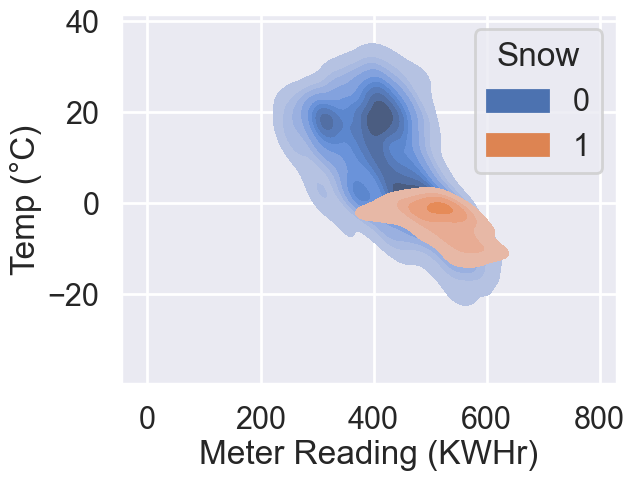

In [129]:
# bivariate analysis with hue
sns.set_context("poster")
sns.set_style('darkgrid')
sns.kdeplot(data=eda_df, x="Meter Reading (KWHr)", y="Temp (°C)", hue="Snow", fill=True)
plt.savefig('Plots/kde.png', dpi=300, bbox_inches='tight')

# Next, we observe the relationship between the "windchill" and the target meter reading

We observe the following: The median values of each wind chill don't vary too much as the wind chill changes. For Wind Chill under -25, Meter Reading limits into a small range. As the wind chill higher, the range expands. Some categories especially its wind chill above -19 have very large range, indicating a wide range of meter reading.

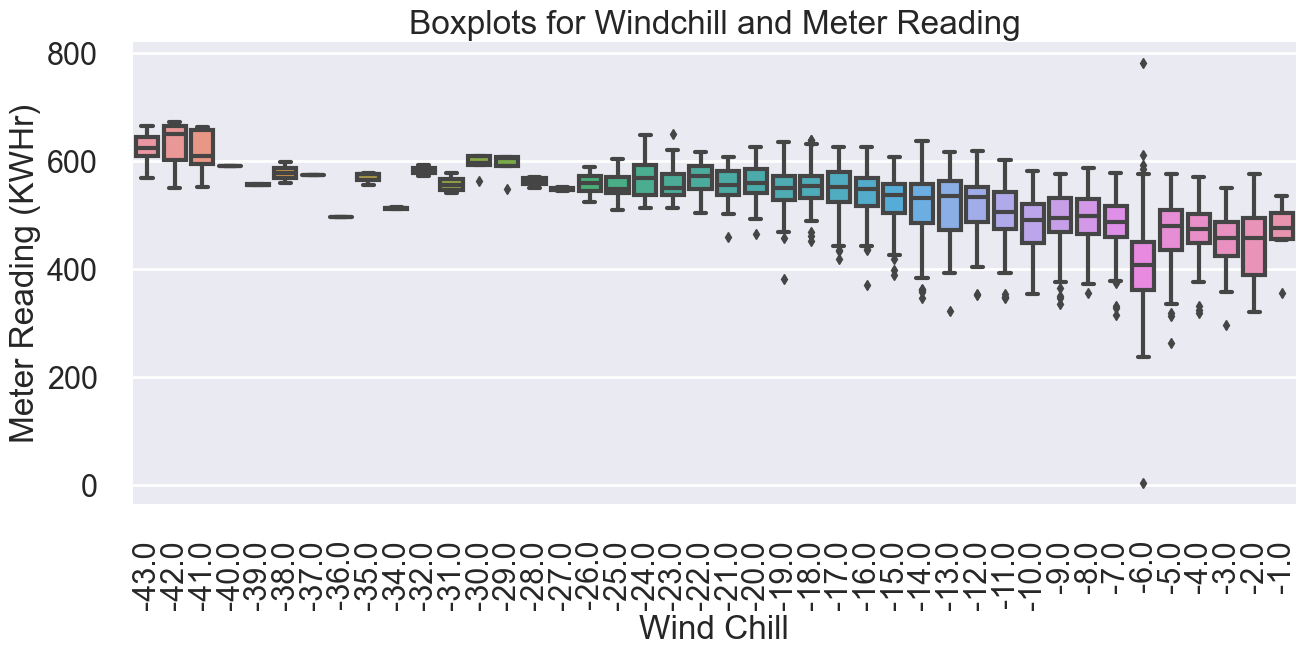

In [128]:
plt.figure(figsize=(15, 6))
boxplot_data=eda_df
boxplot_data=boxplot_data.sort_values(by='Wind Chill')
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Wind Chill", y="Meter Reading (KWHr)",
            data=boxplot_data)

sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.title("Boxplots for Windchill and Meter Reading")
plt.savefig('Plots/box.png', dpi=300, bbox_inches='tight')

## We try to see the relation between "Temperature", "Meter reading" and "Month" using a bivariate plot with marginal distributions.

We can see that except of few outliers in the month of December, most of the data clusters around a meter reading 300-600 KWhr. The highest meter readings are observed around at the end of the year in general and beginning of the year.

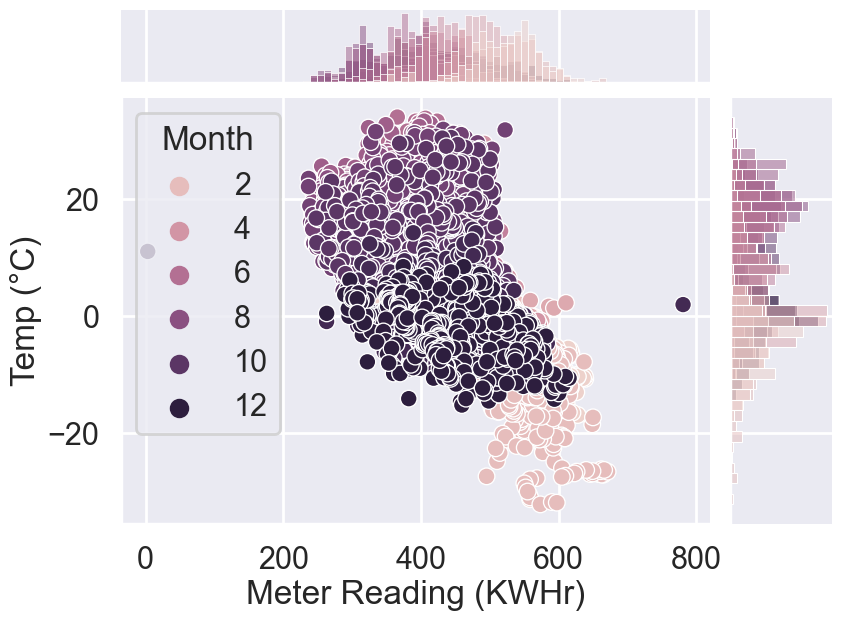

In [127]:
sns.set_style('darkgrid')

g = sns.JointGrid(data=eda_df, x="Meter Reading (KWHr)", y="Temp (°C)", hue="Month")
plt.gcf().set_size_inches(10, 7)
g.plot(sns.scatterplot, sns.histplot)
plt.savefig('Plots/scatter.png', dpi=300, bbox_inches='tight')

# We plot a heat map of variable correlations to observe possible relations between different features in the dataset

We can come up with the following observations:
1. Most of the heat-map shows zero correlations (light purple colour).
2. Meter Reading has a negative correlation with temperature (showing as temperature increases, meter reading decreases, which could hint towards the fact that heating in cold climate consumes more energy than AC usage in summer. 
3. Visibility has negative correlation with fog and mist features, which is as expected.
4. Month and meter reading are negatively correlated - which can indicate the dependency of seasons on energy consumption based on the season change the meter reading varies (higher in winter and lower in winter).
5. Wind chill and Meter reading are negatively correlated which depicts that as there is a decrease in windchill (indicating that it is cold outside), the energy consumption increases and viceversa.
6. Another notable observation made is "windchill is positively correlated to temperature" , When the temperature of air increases, the windchill value also increases because the cooling effect of wind will be less as the temperature becomes warmer. 

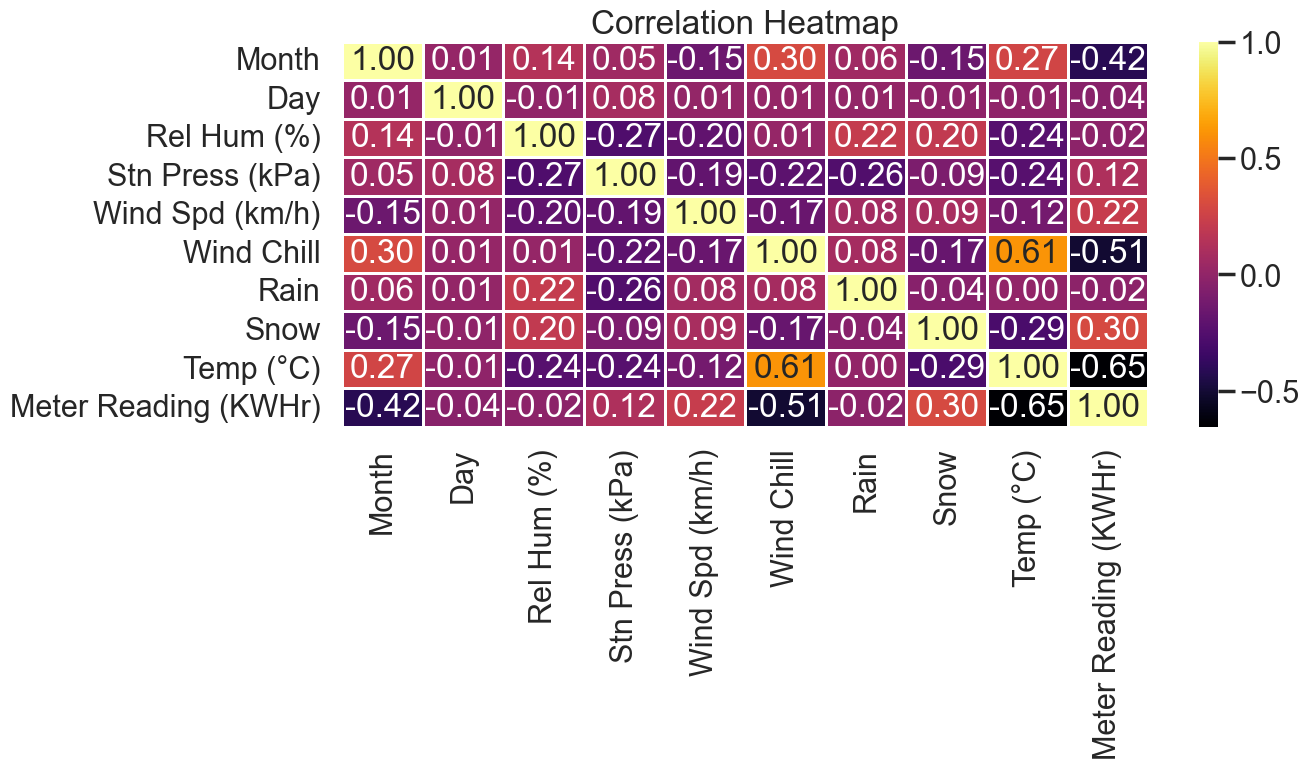

In [126]:
# multivariate correlation between all variables
plt.figure(figsize=(13, 5))
eda_hm_df = eda_df[["Month","Day","Rel Hum (%)","Stn Press (kPa)","Wind Spd (km/h)","Wind Chill","Rain","Snow","Temp (°C)","Meter Reading (KWHr)"]]
sns.heatmap(eda_hm_df.corr(), annot=True, fmt='.2f', cmap='inferno', linewidths=2)
plt.title('Correlation Heatmap')
plt.savefig('Plots/heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Next we try to see the relationship between month and meter readings, and hour of the day and meter reading.

We observe the following: The peaks of the distributions vary between months. Some months have very distinct, high peaks (like March), suggesting that a specific meter reading value occurs more frequently. Other months (like January, November and December) have flatter distributions, indicating a more even spread of meter readings throughout the month.

For hour of the day and meter reading, hours from hour_9 to hour_17 have much wider distributions and higher peaks, indicating higher and more variable consumption or generation. Also, the middle of the day (from hour_10 to hour_15) has higher meter reading values compared to early morning or late evening hours.

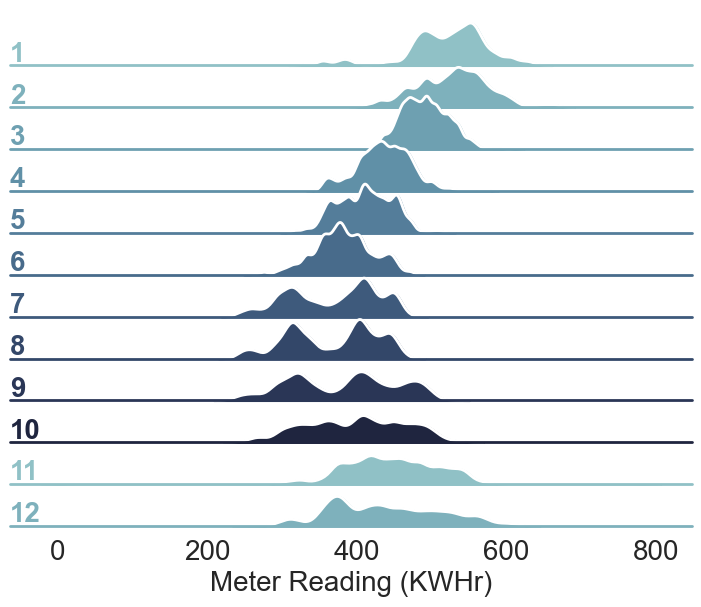

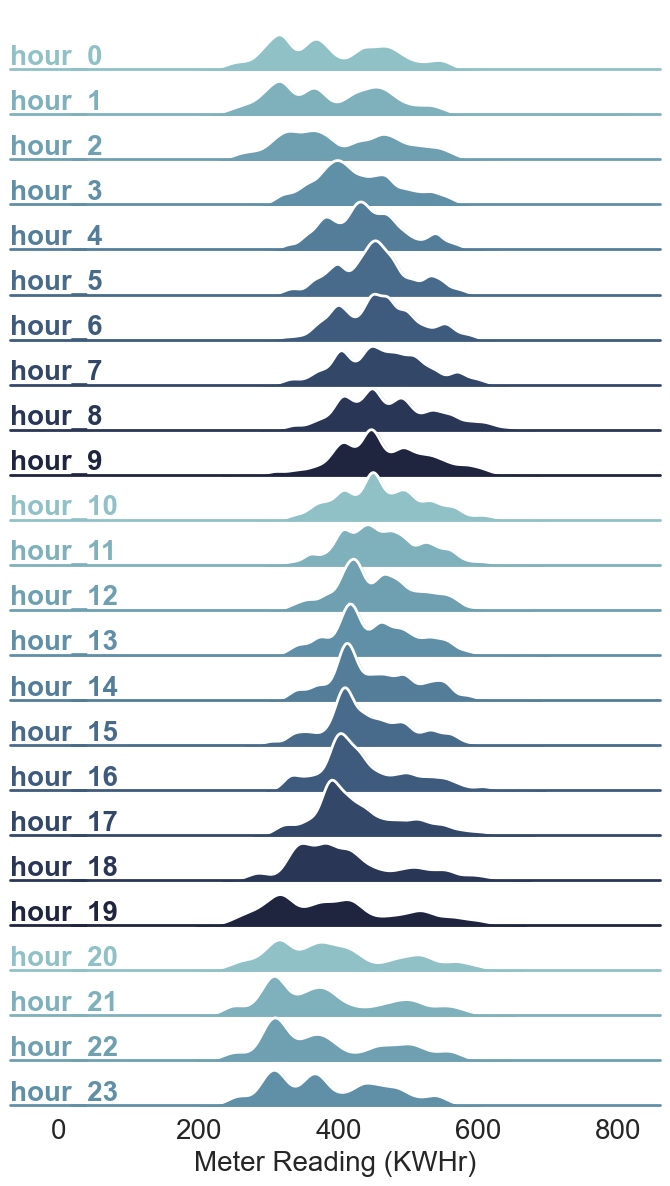

In [141]:
sns.set_context("poster")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

features_of_interest = ["Month", "Time (LST)"]
for feat_of_int in features_of_interest:
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(eda_df, row=feat_of_int, hue=feat_of_int, aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Meter Reading (KWHr)",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "Meter Reading (KWHr)", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center",fontsize=20, transform=ax.transAxes)


    g.map(label, "Meter Reading (KWHr)")
    g.set_axis_labels("Meter Reading (KWHr)", "Y-axis label", fontsize=20)
    for ax in g.axes.flat:
        ax.tick_params(axis='x', labelsize=20)  # Adjust labelsize as needed
        ax.tick_params(axis='y', labelsize=20)

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.savefig(f'Plots/sequence_{feat_of_int}.png', dpi=300, bbox_inches='tight')

# Feature Processing for Model Training

1. Convert categorical variables to one-hot-encoding.
2. Scale/Normalize the resultant features so as to feed a model.

In [46]:
# now we can convert categorical value to their one-hot encoding
# first we get rid of weather column as its converted
data_df.drop(columns=['Weather'], inplace=True)

## Convert categorical variables to their one-hot encoding representations

In [47]:
data_df_exp = pd.get_dummies(data_df, dtype='int64')

In [48]:
scaler = MinMaxScaler()
# now we can perform min-max normalization on all columns before feature preparation
data_df = data_df_exp.drop(columns=['Meter Reading (KWHr)'])
data_df_norm = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)
data_df_norm = pd.concat([data_df_norm, data_df_exp['Meter Reading (KWHr)']], axis=1)

In [49]:
data_df_norm.head(2)

,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Rain,Cloudy,Fog,Drizzle,Clear,Freezing Drizzle,Ice Pellet Showers,Haze,Snow Pellets,Moderate Rain,Moderate Snow,Heavy Rain Showers,Snow Showers,Mainly Clear,Freezing Fog,Freezing Rain,Heavy Snow,Rain Showers,Mostly Cloudy,Blowing Snow,Ice Pellets,Snow,Thunderstorms,Snow Grains,Smoke,Moderate Rain Showers,Time (LST)_hour_0,Time (LST)_hour_1,Time (LST)_hour_2,Time (LST)_hour_3,Time (LST)_hour_4,Time (LST)_hour_5,Time (LST)_hour_6,Time (LST)_hour_7,Time (LST)_hour_8,Time (LST)_hour_9,Time (LST)_hour_10,Time (LST)_hour_11,Time (LST)_hour_12,Time (LST)_hour_13,Time (LST)_hour_14,Time (LST)_hour_15,Time (LST)_hour_16,Time (LST)_hour_17,Time (LST)_hour_18,Time (LST)_hour_19,Time (LST)_hour_20,Time (LST)_hour_21,Time (LST)_hour_22,Time (LST)_hour_23,Meter Reading (KWHr)
0,0.0,0.0,0.53092,0.652755,1.0,0.777778,0.211538,0.016598,0.408935,0.176471,0.880952,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.991
1,0.0,0.0,0.53092,0.652755,1.0,0.722222,0.192308,0.016598,0.417526,0.176471,0.880952,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.707


In [50]:
# Save final preprocessed file
data_df_norm.to_csv("Data/preprocessed_newData.csv", index = False)

# Feature Selection for Regression using Statistical Analysis

In this part we select the most important features for regression. We employ a statistical measure called "Mutual Information" for measuring the correlation of the individual variables to the target variable and decide its feature importance.

In [13]:
df = pd.read_csv("Data/preprocessed_newData.csv")

In [14]:
all_cols = df.columns
target_col = "Meter Reading (KWHr)"
feature_col = all_cols.drop(target_col).tolist()
target_col = [target_col]
# we use mutual info regression to determine feature importance (as F-statistic) can only capture linear dependencies
# between feature and the target variable
features_df = df[feature_col]
target_df = df[target_col]

mi_scores = mutual_info_regression(features_df, target_df)

# create a mapping from column name to value
feature_imp_map = {feature:mi_scores[i] for i, feature in enumerate(features_df.columns)}
# sort the values
sorted_feature_imp = sorted(feature_imp_map.items(), key=lambda x: -x[1])

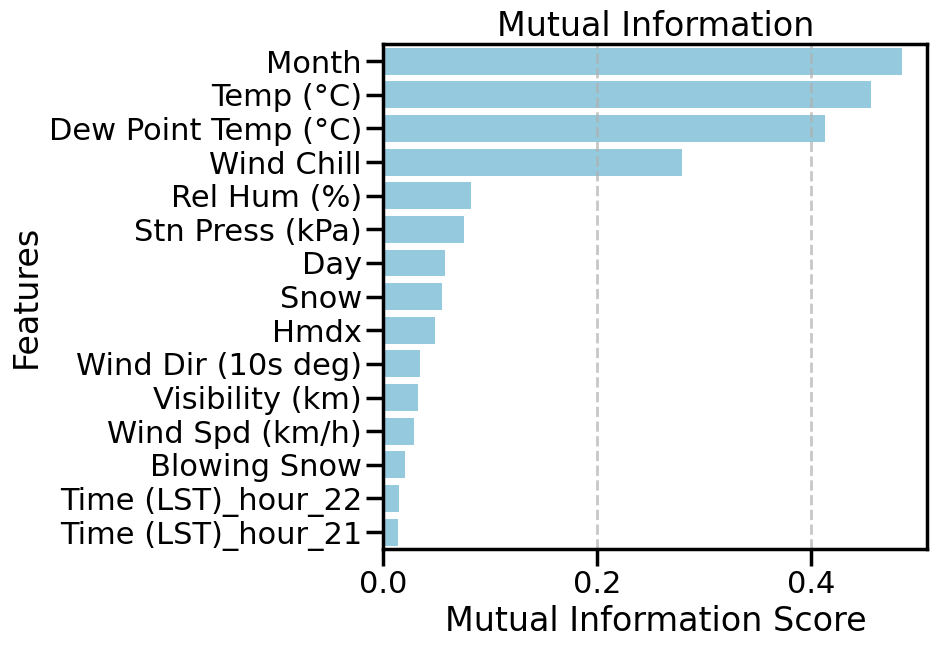

In [15]:
sns.set_context("poster")
plt.figure(figsize=(10, 7))
# Extracting labels and values
labels, values = zip(*sorted_feature_imp)

df_plot = pd.DataFrame({"MI Score": values[:15],"Features": labels[:15]})

sns.barplot(df_plot, x="MI Score", y="Features", color='skyblue')

plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(f'Plots/feature_imp.png', dpi=300, bbox_inches='tight')
plt.show()

## We can note the feature importances of the data from the above graph (its skewed to the right)
1.  The categorical features for hour and type of weather have very less importance according to mutual information with the target variable
2.  For the purpose of this experiment, we select the top-k features where k is determined based on the first index where feature impotance becomes 0 (features arranged in decreasing order of magnitude of the feature importance)

In [16]:
# find features with zero importance 
filtered_features = [entry[0] for entry in sorted_feature_imp if entry[1]!=0]
print("Filtered Final Features: ", filtered_features, "\n\nTotal Features: ", len(filtered_features))

Filtered Final Features:  ['Month', 'Temp (°C)', 'Dew Point Temp (°C)', 'Wind Chill', 'Rel Hum (%)', 'Stn Press (kPa)', 'Day', 'Snow', 'Hmdx', 'Wind Dir (10s deg)', 'Visibility (km)', 'Wind Spd (km/h)', 'Blowing Snow', 'Time (LST)_hour_22', 'Time (LST)_hour_21', 'Time (LST)_hour_23', 'Time (LST)_hour_1', 'Time (LST)_hour_0', 'Smoke', 'Time (LST)_hour_10', 'Time (LST)_hour_11', 'Time (LST)_hour_20', 'Time (LST)_hour_8', 'Time (LST)_hour_18', 'Time (LST)_hour_12', 'Time (LST)_hour_16', 'Time (LST)_hour_7', 'Time (LST)_hour_14', 'Rain', 'Mostly Cloudy', 'Time (LST)_hour_19', 'Time (LST)_hour_13', 'Time (LST)_hour_17', 'Time (LST)_hour_5', 'Time (LST)_hour_6', 'Time (LST)_hour_4', 'Time (LST)_hour_9', 'Freezing Rain', 'Time (LST)_hour_3', 'Rain Showers', 'Time (LST)_hour_15', 'Fog', 'Time (LST)_hour_2', 'Snow Showers', 'Drizzle', 'Freezing Drizzle', 'Ice Pellets', 'Clear', 'Moderate Snow', 'Moderate Rain', 'Heavy Rain Showers', 'Moderate Rain Showers', 'Thunderstorms', 'Haze', 'Freezing Fo

In [17]:
final_features_df = features_df[filtered_features]
final_target_df = target_df

In [18]:
# saving final features df
final_features_df.to_csv("Data/final_features_newData.csv")

In [19]:
final_dataset_comb = pd.concat([final_features_df,final_target_df], axis=1)
final_dataset_comb.to_csv("Data/final_data.csv")

# Train and Evaluate Models

## Random Forests & Multi-Layer Perceptrons

We use 5-fold cross-validation for all the experiments. 5 folds, leaves 4 folds for training and 1 fold for testing in each cycle. Totally there will be 5 cycles and we average the results on the test set for obtaining the final model performance. By construction each fold has 80% training data (4 folds x 20) and 20% testing data (1 fold x 20). For the purpose of comparing model performances we use the MSE (Mean Squared Error) metric. The MSE metric can only be compared w.r.t to a baseline model. Hence, we use a random predictor regressor as a baseline to determine the improvement in MSE we achieved by training the Random Forest model and MLP model.

In [7]:
# we can now evaluate the models using k-fold cross-val
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)


scores_folds_rf, scores_folds_mlp, scores_folds_baseline = [], [], []
scores_r2_rf, scores_r2_mlp, scores_r2_baseline = [], [], []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(final_features_df)), total=num_folds):
    # form the splits
    train_x, train_y = final_features_df.iloc[train_index], final_target_df.iloc[train_index]
    test_x, test_y = final_features_df.iloc[test_index], final_target_df.iloc[test_index]
    
    # now train the model
    
    # create a baseline
    # Modelb: baseline
    baseline_model_pred = np.random.uniform(low=test_y.min(), high=test_y.max(), size=len(test_y))
    mse_score = mean_squared_error(test_y,baseline_model_pred)
    scores_r2_baseline.append(r2_score(test_y, baseline_model_pred))
    scores_folds_baseline.append(mse_score)
    
    # Model1: Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
    rf_model.fit(train_x, train_y)
    rf_model_pred = rf_model.predict(test_x)
    mse_score = mean_squared_error(test_y, rf_model_pred)
    scores_r2_rf.append(r2_score(test_y, rf_model_pred))
    scores_folds_rf.append(mse_score)
    
    # Model2: MultiLayer Perceptron Regressor
    # alpha is L2 
    mlp_model = MLPRegressor(hidden_layer_sizes=(100,50,100), activation='relu', solver='adam', random_state=42, alpha=0.01)
    mlp_model.fit(train_x, train_y)
    mlp_model_pred = mlp_model.predict(test_x)
    mse_score = mean_squared_error(test_y, mlp_model_pred)
    scores_r2_mlp.append(r2_score(test_y, mlp_model_pred))
    scores_folds_mlp.append(mse_score)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:47<00:00, 45.41s/it]


# Model Performance: Quantitative Analysis (Mean Squared Error - MSE)

We compute the MSE averaged across all the 5 folds for all the three models (RF, MLP and Random baseline).

In [8]:
# table of scores
exp_table = {
    "models": ["baseline","Random Forest","MLP"],
    "fold 1": [scores_folds_baseline[0],scores_folds_rf[0],scores_folds_mlp[0]],
    "fold 2": [scores_folds_baseline[1],scores_folds_rf[1],scores_folds_mlp[1]],
    "fold 3": [scores_folds_baseline[2],scores_folds_rf[2],scores_folds_mlp[2]],
    "fold 4": [scores_folds_baseline[3],scores_folds_rf[3],scores_folds_mlp[3]],
    "fold 5": [scores_folds_baseline[4],scores_folds_rf[4],scores_folds_mlp[4]]
}
exp_df = pd.DataFrame(exp_table)
exp_df["Avg."] = exp_df.apply(lambda x: (x["fold 1"]+x["fold 2"]+x["fold 3"]+x["fold 4"]+x["fold 5"])/5.0, axis=1)
exp_df = exp_df.round(2)
exp_df

,models,fold 1,fold 2,fold 3,fold 4,fold 5,Avg.
0,baseline,19369.00,50029.06,21276.68,36821.93,20215.07,29542.35
1,Random Forest,866.12,944.44,939.66,1011.76,875.02,927.40
2,MLP,1267.91,1318.21,1385.07,1371.93,1291.57,1326.94


In [9]:
exp_df.to_csv("Data/tabular_results.csv")

In [10]:
# average score across all folds for all the models under consideration
avg_rf_score = sum(scores_folds_rf)/len(scores_folds_rf)
avg_mlp_score = sum(scores_folds_mlp)/len(scores_folds_mlp)
avg_baseline_score = sum(scores_folds_baseline)/len(scores_folds_baseline)
print(f"Average MSE of Random Forest: {avg_rf_score}")
print(f"Average MSE of MLP Model: {avg_mlp_score}")
print(f"Average MSE of baseline Model (Random Predictor): {avg_baseline_score}")

Average MSE of Random Forest: 927.4011123947378
Average MSE of MLP Model: 1326.939991917392
Average MSE of baseline Model (Random Predictor): 29542.34603403621


# Model Performance: (R2 - Score)

We perform the Statistical Tests here. R² represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. Closer to 1 means the model performs better. We can see that Random Forest Regression has a better R².

R² can determine how well the model fits the data. Compared to MSE, R² is a normalized version of MSE and is often easier to interpret since it doesn't depend on the scale of the data.

In [11]:
# table of scores
exp_table_r2 = {
    "models": ["baseline","Random Forest","MLP"],
    "fold 1": [scores_r2_baseline[0],scores_r2_rf[0],scores_r2_mlp[0]],
    "fold 2": [scores_r2_baseline[1],scores_r2_rf[1],scores_r2_mlp[1]],
    "fold 3": [scores_r2_baseline[2],scores_r2_rf[2],scores_r2_mlp[2]],
    "fold 4": [scores_r2_baseline[3],scores_r2_rf[3],scores_r2_mlp[3]],
    "fold 5": [scores_r2_baseline[4],scores_r2_rf[4],scores_r2_mlp[4]]
}
exp_df = pd.DataFrame(exp_table_r2)
exp_df["Avg."] = exp_df.apply(lambda x: (x["fold 1"]+x["fold 2"]+x["fold 3"]+x["fold 4"]+x["fold 5"])/5.0, axis=1)
exp_df = exp_df.round(2)
exp_df

,models,fold 1,fold 2,fold 3,fold 4,fold 5,Avg.
0,baseline,-2.28,-7.12,-2.82,-4.93,-2.50,-3.93
1,Random Forest,0.85,0.85,0.83,0.84,0.85,0.84
2,MLP,0.79,0.79,0.75,0.78,0.78,0.78


In [12]:
exp_df.to_csv("Data/tabular_results_r2.csv")

# Model Performance: Qualitative Analysis

In this section we perform a series of model performance vizualizations. The model outputs are compared to that of the real values from the ground truth in addition to comparison of model output w.r.t to each other (Random Forest vs Multi-layer perceptron). We perform analysis on an arbitrary fold without loss of generalization.

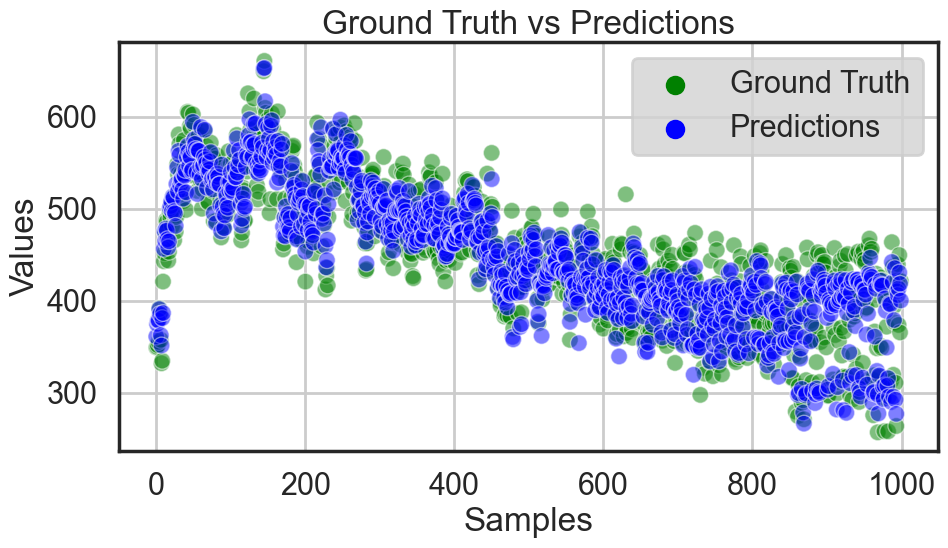

In [177]:
# scatter plot of the first_k data samples of the last fold in k-fold (arbitrarily chosen to see if model learns the patterns)
first_k = 1000
sample_pred = rf_model.predict(test_x)[:first_k]
sample_gt = test_y.iloc[:, 0].values[:first_k]

# Create scatter plots for predictions and ground truth
data = {
    'index': list(range(len(sample_gt))) + list(range(len(sample_pred))),
    'value': np.concatenate([sample_gt,sample_pred],axis=0),
    'type': ['Ground Truth'] * len(sample_gt) + ['Predictions'] * len(sample_pred)
}
df_scatter = pd.DataFrame(data)

# Plotting the scatter plot with Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scatter, x='index', y='value', hue='type', palette=['green', 'blue'], alpha=0.5)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Ground Truth vs Predictions')

# plt.legend()
plt.grid(True)
plt.legend(facecolor='lightgrey')

plt.tight_layout()
plt.savefig(f'Plots/results_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

## Analysis of Model residuals

By plotting the residuals plot, we can observe the following: For the Random Forest, the residuals are mostly centered around zero and it is desirable in a well-fitting model. Also the majority of the residuals fall within the range of approximately -50 to 50, indicating that most predictions are within this range of the actual values.
For the MultiLayer Perceptron Regresssion, this distribution of residuals is also centered around zero. The peak of the histogram for the Multilayer Perceptron Model is higher than that of the Random Forest, suggesting a tighter clustering of residuals around the mean.For both models, the fact that residuals are centered around zero suggests that neither model has a significant bias or variance and are sufficiently accurate given the test data.

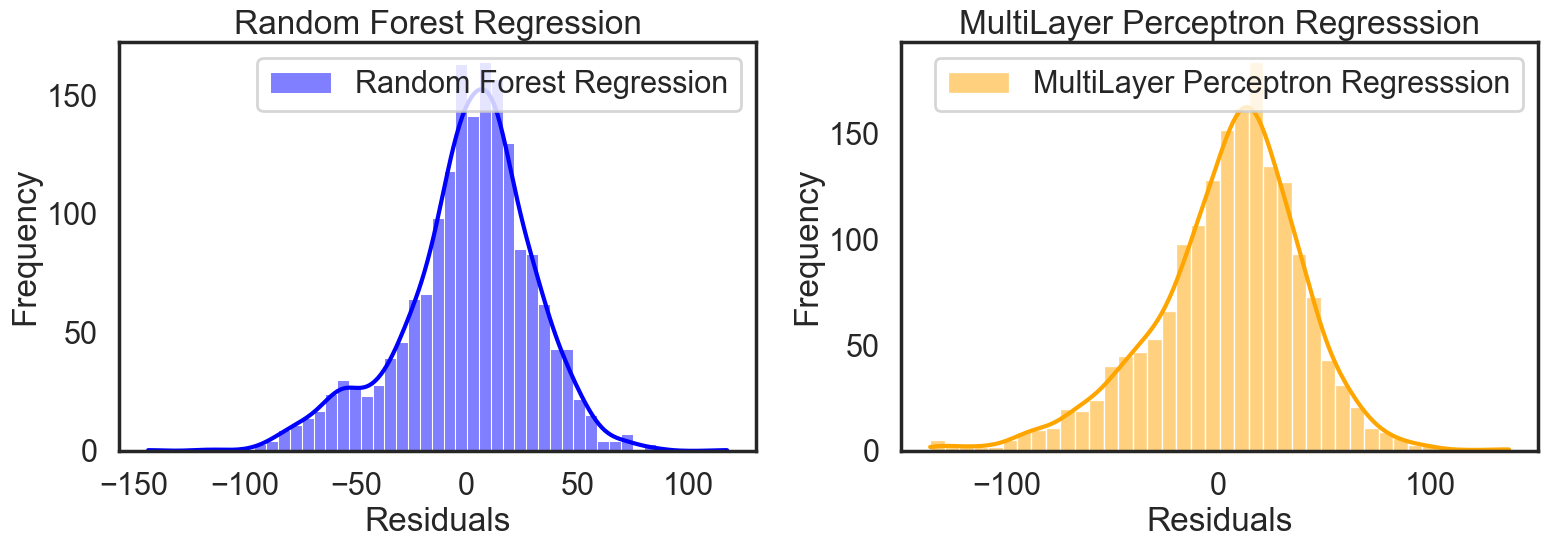

In [182]:
residuals1 = test_y['Meter Reading (KWHr)']- rf_model_pred
residuals2 = test_y['Meter Reading (KWHr)']- mlp_model_pred

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals1, kde=True, color='blue', label='Random Forest Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Random Forest Regression')
plt.legend(facecolor='white')

plt.subplot(1, 2, 2)
sns.histplot(residuals2, kde=True, color='orange', label='MultiLayer Perceptron Regresssion')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('MultiLayer Perceptron Regresssion')
plt.legend(facecolor='white')

plt.tight_layout()
plt.savefig(f'Plots/results_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

## Quantile-Quantile (qq) plot on Model errors

Plotting the QQ plot, lets us analyze the distribution of errors w.r.t to the true labels. If it follows a normal distribution, then the points would overlap with the diagonal line. If both models errors have the same degree of overlap with the 45 degree line, then it means their errors also follow a similar distribution. Its an alternate representation to compare the error distributions of the RR and MLP models.

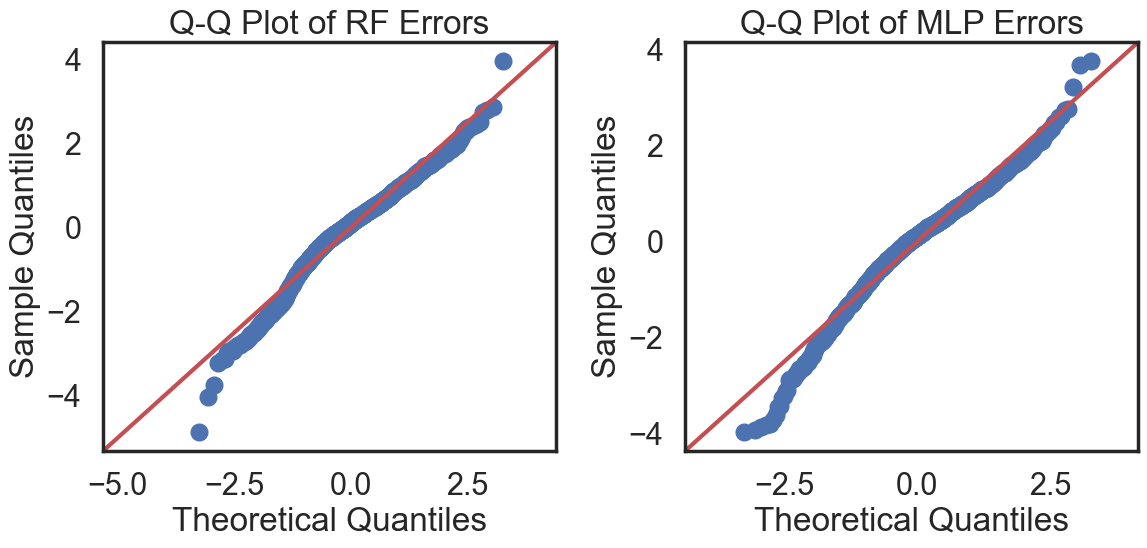

In [185]:
Q_Q1 = test_y['Meter Reading (KWHr)']- rf_model_pred
Q_Q2 = test_y['Meter Reading (KWHr)']- mlp_model_pred


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sm.qqplot(Q_Q1, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot of RF Errors')


plt.subplot(1, 2, 2)
sm.qqplot(Q_Q2, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot of MLP Errors')

plt.tight_layout()
plt.savefig(f'Plots/results_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

## Bland-Altman Plot
By observing the Bland-Altman plot, we can assess the consistency between the prediction results of two models. If most points closely cluster around the mean difference line and are evenly distributed within the limits of agreement (which we define by a constant times of standard deviation), it suggests that the two models have good consistency in terms of their predicted power consumption or usage. If the differences systematically increase or decrease as the mean values increase, it may indicate the presence of some sort of proportional bias.

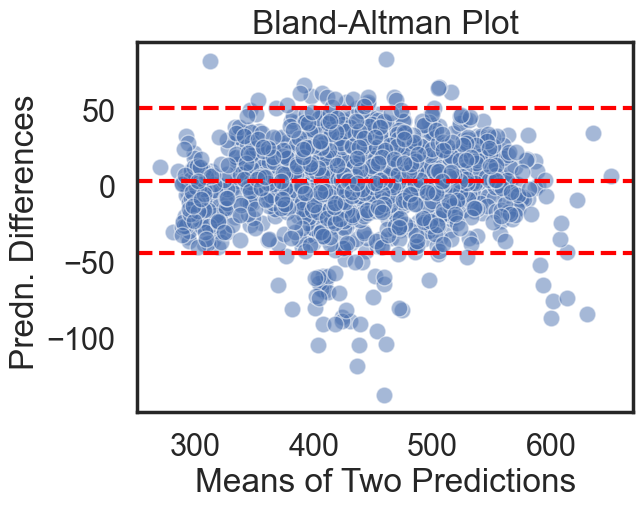

In [188]:
pred1=rf_model_pred
pred2=mlp_model_pred
means = (pred1 + pred2) / 2
differences = pred1 - pred2
mean_difference = np.mean(differences)
std_difference = np.std(differences)

data = {
    "means": means,
    "values": differences
}

df_ba_plot = pd.DataFrame(data)
sns.scatterplot(df_ba_plot, x = "means", y = "values", alpha=0.5)
plt.axhline(mean_difference, color='red', linestyle='--')  
plt.axhline(mean_difference + 1.96*std_difference, color='red', linestyle='--')  
plt.axhline(mean_difference - 1.96*std_difference, color='red', linestyle='--')  
plt.title('Bland-Altman Plot')
plt.xlabel('Means of Two Predictions')
plt.ylabel('Predn. Differences ')
plt.savefig(f'Plots/results_bland_altman.png', dpi=300, bbox_inches='tight')
plt.show()